# Summary
In this notebook we create plots for the following comparisons:
* LFY ChIP-Seq (Jin 2021) vs LFY ChIP-chip (Winter 2011)
* FD ChIP-Seq (Zhu 2020) vs FD ChIP-Seq (Collani 2019)

# Set up Environment
get libraries

In [1]:
import pandas as pd
import numpy as np
import os

# plotting libraries
from plotnine import *
%matplotlib inline

# LFY ChIP

import table of data

In [2]:
lfy_pooled_df = pd.read_csv("../data/lfy_pooled_chipComparisons.tsv",sep="\t")
lfy_pooled_df.tail()

,samples,mask_ultrahigh_signals,control,dups,total,peaksOverlap_GS,peaksOverlap_BL,peaksOverlap_LFYChIPchip,peaksOverlap_LFYChIPchip_and_GS,peaksOverlap_LFYChIPchip_and_BL
1,LFY,noScreen,input,True,1680,50,62,704,0,0
2,LFY,noScreen,mock,True,998,14,14,551,0,0
3,LFY,GS,input,True,1630,0,12,704,0,0
4,LFY,BL,input,True,1656,0,0,698,0,0
5,LFY,noScreen,input,False,1293,60,66,633,0,0


Add columns and change values of specific columns. This will be useful for labeling the plots downstream.

In [3]:
def decorate(pooled_df):

    # instead of True and False for the "dups" column
    # I want to have strings "wiDups" or "noDups"
    # respectively
    pooled_df["dups"] = \
        pooled_df["dups"].replace(
            [True, False],
            ["wiDups","noDups"])

    # replace Control strings
    pooled_df["control"] = \
        pooled_df["control"].replace(
            ["none", "input", "mock"],
            ["noControl","inputControl","mockControl"])

    # create a column that includes all
    # the parameters as well as the total
    # number of peaks
    pooled_df['dups_control_gs_total']= \
        pooled_df.agg(
            lambda x: f"{x['dups']},\n{x['control']},\n{x['mask_ultrahigh_signals']}\n[n={x['total']}]", axis=1)
    return(pooled_df)

In [4]:
lfy_pooled_df = decorate(lfy_pooled_df)

plot values in a stacked bar chart

In [5]:
def plotOverlapStackedBarChart_V3(pool_df,
                                  gs_overlap_col,
                                  samp_overlap_col,
                                  plot_title,
                                 xlabels,
                                 axis_font_size=12):
    
    # melt table to give overlap count values for each
    # set of parameters
    cats_of_interest=[gs_overlap_col, samp_overlap_col]
    
    pool_melted_df = pd.melt(pool_df,
        id_vars=[xlabels],
        value_vars=cats_of_interest)
    pool_melted_df["variable_cat"] = \
        pd.Categorical(pool_melted_df['variable'], 
                       categories=cats_of_interest)
    # generate plot using plotnine library
    pool_plot = (ggplot(
        pool_melted_df, 
        aes(x=xlabels, y='value', 
            fill='variable_cat')) + 
        geom_bar(stat='identity', position='stack') + 
        labs(title=plot_title,
              y="Number of Peaks",
              x="Sample",fill="") + 
         theme(title = element_text(size=14),
               axis_text_x=element_text(size=axis_font_size),
               axis_text_y=element_text(size=axis_font_size),
              strip_background = element_blank(),
              strip_margin=0,
              strip_margin_x=0.4,
              strip_margin_y=0.4,
              legend_position=(.5,-.15),
              legend_direction = "horizontal",
              panel_background=element_blank(),
              axis_line = element_line(size=1, colour = "black"),
              panel_grid_major = element_line(colour = "#d3d3d3")) +
        geom_text(aes(label='value'), size = 20, position = position_stack(vjust = 0.5))
    )
    return(pool_plot)

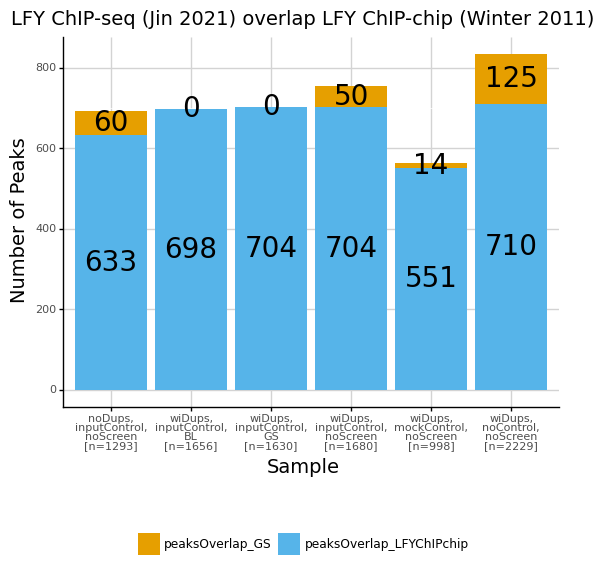

<ggplot: (8727694987261)>

In [6]:
plot=(plotOverlapStackedBarChart_V3(lfy_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_LFYChIPchip",
                           "LFY ChIP-seq (Jin 2021) overlap LFY ChIP-chip (Winter 2011)",
                            "dups_control_gs_total",8) + 
                 scale_fill_manual(values=["#E69F00", "#56B4E9"])
)
plot

# FD ChIP

import table of data

In [7]:
fd_pooled_df = pd.read_csv("../data/fd_pooled_chipComparisons.tsv",sep="\t")
fd_pooled_df.tail()

,samples,mask_ultrahigh_signals,control,dups,total,peaksOverlap_GS,peaksOverlap_BL,peaksOverlap_FDSchmid,peaksOverlap_FDSchmidChIPseq_and_GS,peaksOverlap_FDSchmidChIPseq_and_BL
1,FD,noScreen,input,True,5192,5,16,4269,0,5
2,FD,noScreen,mock,True,4244,0,7,3629,0,4
3,FD,GS,input,True,5187,0,11,4269,0,5
4,FD,BL,input,True,5322,0,0,4368,0,0
5,FD,noScreen,input,False,4420,9,19,3764,0,6


In [8]:
fd_pooled_df = decorate(fd_pooled_df)

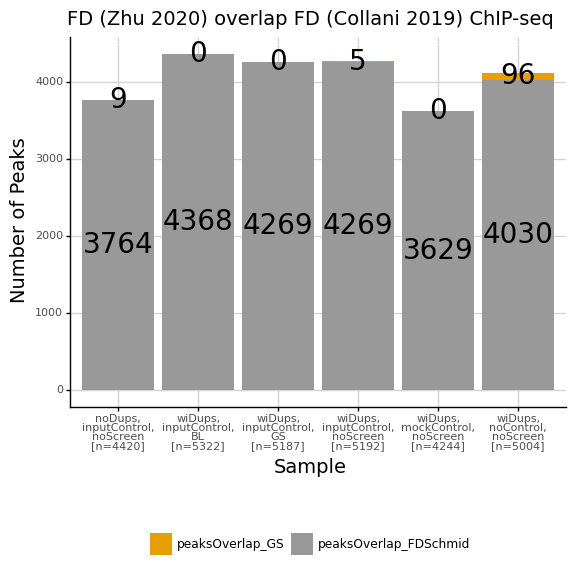

<ggplot: (8727692677879)>

In [9]:
plot=(plotOverlapStackedBarChart_V3(fd_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_FDSchmid",
                           "FD (Zhu 2020) overlap FD (Collani 2019) ChIP-seq",
                            "dups_control_gs_total",8) + 
                 scale_fill_manual(values=["#E69F00", "#999999"])
)
plot